In [1]:
# Import necessary libraries
import pandas as pd
import ast
from datetime import datetime
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Set paths
dataset_path = r"C:\Users\Admin\Downloads\cleaned_dataset"
data_path = os.path.join(dataset_path, "data")
metadata_file = os.path.join(dataset_path, "metadata.csv")
pio.renderers.default = 'iframe_connected'

In [3]:
metadata_df = pd.read_csv(metadata_file)

In [4]:
# Filtering out dataset with type impedance and also creating original dataframe of dataset
impedance_df = metadata_df[metadata_df['type'] == 'impedance'][['start_time', 'Re', 'Rct', 'battery_id']]
dataset_df = metadata_df[metadata_df['type'] == 'impedance'][['start_time', 'filename', 'battery_id']]

In [5]:
impedance_df = impedance_df.dropna(subset=['start_time'])

impedance_df = impedance_df.sort_values(by='start_time')

In [6]:
# Converting start time to appropriate format
from datetime import datetime

def parse_start_time(value):
    try:
        if isinstance(value, str):
            value = value.strip("[]").replace(",", "")
            components = [float(x) for x in value.split()]
            if len(components) == 6:
                year, month, day, hour, minute = map(int, components[:5])
                second = int(components[5])
                return datetime(year, month, day, hour, minute, second)
    except (ValueError, SyntaxError, TypeError):
        return pd.NaT
    return pd.NaT

# Parsing start time in both datasets
dataset_df['start_time'] = dataset_df['start_time'].apply(parse_start_time)
impedance_df['start_time'] = impedance_df['start_time'].apply(parse_start_time)

In [7]:
# Dropping null values and sorting based on start time 
impedance_df = impedance_df.dropna(subset=['start_time'])
impedance_df = impedance_df.sort_values(by='start_time')

dataset_df = dataset_df.dropna(subset=['start_time'])
dataset_df = dataset_df.sort_values(by='start_time')


In [8]:
# Printing list of batteries in dat
print(impedance_df['battery_id'].unique())

['B0005' 'B0006' 'B0007' 'B0018' 'B0027' 'B0025' 'B0028' 'B0026' 'B0032'
 'B0031' 'B0030' 'B0029' 'B0033' 'B0036' 'B0034' 'B0040' 'B0038' 'B0039'
 'B0043' 'B0044' 'B0042' 'B0041' 'B0047' 'B0045' 'B0048' 'B0046' 'B0052'
 'B0049' 'B0051' 'B0050' 'B0054' 'B0056' 'B0055' 'B0053']


In [9]:
#Filtering out information for each battery_id and plotting curves
for battery_id in impedance_df['battery_id'].unique() :
    current_battery_info = impedance_df[impedance_df['battery_id'] == battery_id]
    # print(current_battery_info)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=current_battery_info['start_time'], 
        y=current_battery_info['Re'], 
        mode='lines', 
        name='Re',
        line=dict(color='green')
    ))
    fig.add_trace(go.Scatter(
        x=current_battery_info['start_time'], 
        y=current_battery_info['Rct'], 
        mode='lines', 
        name='Rct',
        line=dict(color='blue')
    ))
    fig.update_layout(
        title=f"Resistance (Battery ID: {battery_id})",
        xaxis_title="Start Time",
        yaxis_title="Resistance (Ohms)",
        xaxis=dict(tickangle=45),
        legend_title="Legend",
        template="plotly"
    )
    fig.show()

In [10]:
battery_info = {}
for idx, row in dataset_df.iterrows() :
    battery_id = row['battery_id']
    filename = row['filename']
    start_time = row['start_time']
    filePath = fr"C:\Users\Admin\Downloads\cleaned_dataset\data\{filename}"
    try:
        data = pd.read_csv(filePath)
        
        if 'Battery_impedance' in data.columns:
            impedance_values = data['Battery_impedance'].apply(lambda x: complex(x).real)
            avg_impedance = impedance_values.mean()
            if battery_id not in battery_info:
                battery_info[battery_id] = {'start_time': [], 'battery_impedance': []}
            battery_info[battery_id]['start_time'].append(start_time)
            battery_info[battery_id]['battery_impedance'].append(avg_impedance)
        else:
            print(f"'Battery_impedance' column not found in {filename}")
    except Exception as e:
        print(f"Error occurred with {filename}: {e}")
for battery_id, data in battery_info.items():
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data['start_time'],
                                 y=data['battery_impedance'],
                                 mode='lines',
                                 name=f'Battery {battery_id}')
                     )
        fig.update_layout(
            title=f'Battery impedance change over time for battery {battery_id}',
            xaxis_title='Start Time',
            yaxis_title='Battery Impedance (Ohms)',
            xaxis=dict(tickangle=45),
            template='plotly'
        )
        fig.show()


In [11]:
# Convert impedance values to numeric
metadata_df["Re"] = pd.to_numeric(metadata_df["Re"], errors="coerce")
metadata_df["Rct"] = pd.to_numeric(metadata_df["Rct"], errors="coerce")
metadata_df["Capacity"] = pd.to_numeric(metadata_df["Capacity"], errors="coerce")

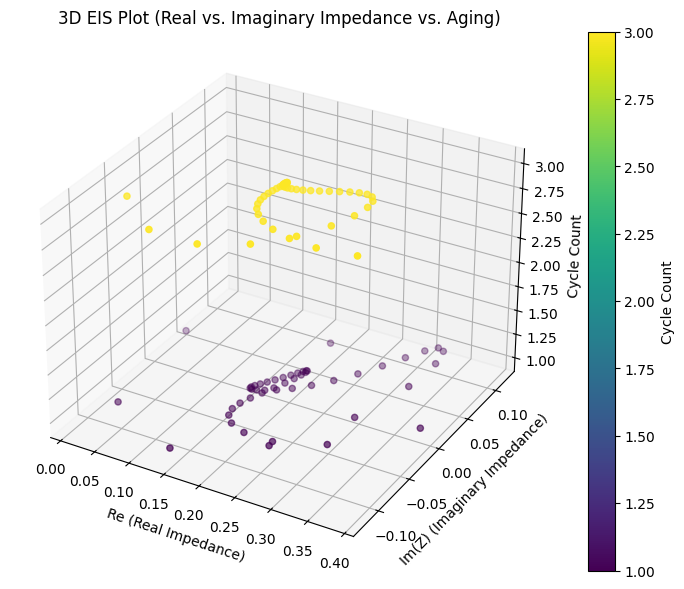

In [12]:
#Naveenkumar P
# -------------------------
# 1. Extract and Visualize 3D EIS Data
# -------------------------

# Load impedance data from files containing 'Battery_impedance'
impedance_data = []
for filename in ["00002.csv", "00004.csv"]:  # Sample impedance files
    file_path = os.path.join(data_path, filename)
    df = pd.read_csv(file_path)
    
    # Ensure the Battery_impedance column exists
    if "Battery_impedance" in df.columns:
        # Convert complex impedance from string to numerical format
        df["Battery_impedance"] = df["Battery_impedance"].apply(lambda x: complex(x) if isinstance(x, str) else x)
        
        # Extract Real (Re) and Imaginary (Im(Z)) parts
        df["Re"] = df["Battery_impedance"].apply(lambda z: z.real)
        df["Im(Z)"] = df["Battery_impedance"].apply(lambda z: z.imag)
        
        # Assign Cycle number from metadata
        cycle_number = metadata_df.loc[metadata_df["filename"] == filename, "test_id"].values[0]
        df["Cycle"] = cycle_number
        
        # Append selected columns
        impedance_data.append(df[["Re", "Im(Z)", "Cycle"]])

# Combine extracted impedance data
if impedance_data:
    impedance_df = pd.concat(impedance_data)

    # 3D EIS Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(impedance_df["Re"], impedance_df["Im(Z)"], impedance_df["Cycle"], c=impedance_df["Cycle"], cmap="viridis")

    ax.set_xlabel("Re (Real Impedance)")
    ax.set_ylabel("Im(Z) (Imaginary Impedance)")
    ax.set_zlabel("Cycle Count")
    ax.set_title("3D EIS Plot (Real vs. Imaginary Impedance vs. Aging)")
    fig.colorbar(scatter, label="Cycle Count")
    plt.show()
else:
    print("No valid impedance data extracted.")

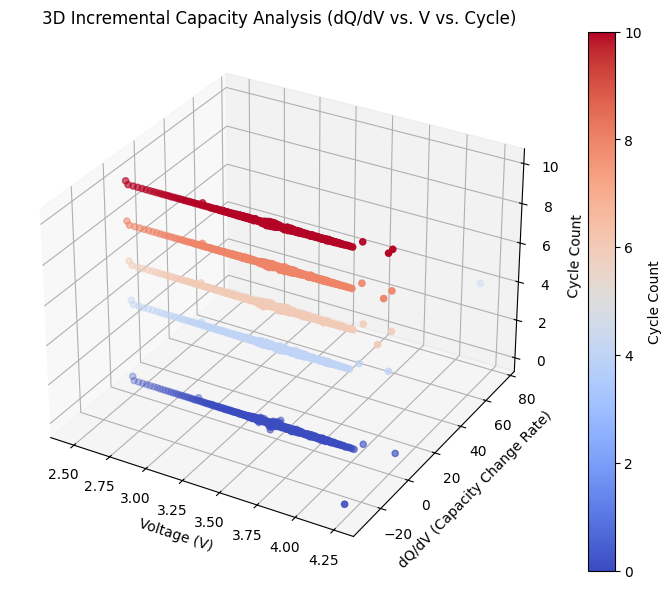

In [13]:
#Naveenkumar P
# -------------------------
# 2. Compute and Visualize Incremental Capacity Analysis (dQ/dV) 
# -------------------------

# Filter discharge cycle files
discharge_files = metadata_df[metadata_df["type"] == "discharge"]["filename"].dropna().tolist()

# Extract discharge cycle data for dQ/dV analysis
discharge_data = []
for filename in discharge_files[:5]:  # Use a small sample to ensure efficiency
    file_path = os.path.join(data_path, filename)
    if os.path.exists(file_path):  # Ensure file exists
        df = pd.read_csv(file_path)
        if "Voltage_measured" in df.columns and "Current_measured" in df.columns:
            df["dQ/dV"] = np.gradient(df["Current_measured"]) / np.gradient(df["Voltage_measured"])  # Compute dQ/dV
            df["Cycle"] = metadata_df.loc[metadata_df["filename"] == filename, "test_id"].values[0]  # Assign Cycle
            discharge_data.append(df[["Voltage_measured", "dQ/dV", "Cycle"]])

# If valid data exists, proceed with 3D plotting
if discharge_data:
    dq_dv_data = pd.concat(discharge_data)

    # 3D dQ/dV Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(dq_dv_data["Voltage_measured"], dq_dv_data["dQ/dV"], dq_dv_data["Cycle"], c=dq_dv_data["Cycle"], cmap="coolwarm")

    ax.set_xlabel("Voltage (V)")
    ax.set_ylabel("dQ/dV (Capacity Change Rate)")
    ax.set_zlabel("Cycle Count")
    ax.set_title("3D Incremental Capacity Analysis (dQ/dV vs. V vs. Cycle)")
    fig.colorbar(scatter, label="Cycle Count")
    plt.show()
else:
    print("No valid discharge cycle data found for dQ/dV analysis.")

In [14]:
#Naveenkumar P
# -------------------------
# 3. Train ML Model to Predict Capacity from EIS Data
# -------------------------

# Prepare data for ML model
if not impedance_df.empty and "Cycle" in impedance_df.columns:
    # Merge impedance data with capacity values from metadata
    ml_data = impedance_df.merge(metadata_df[["test_id", "Capacity"]], left_on="Cycle", right_on="test_id", how="inner")

    # Drop rows with missing capacity values
    ml_data = ml_data.dropna(subset=["Capacity"])

    # Features (Re, Im(Z)) and Target (Capacity)
    X = ml_data[["Re", "Im(Z)"]]
    y = ml_data["Capacity"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Model Evaluation:\nRMSE: {rmse:.4f}, R²: {r2:.4f}")
else:
    print("Not enough impedance data available for ML training.")


Model Evaluation:
RMSE: 0.4250, R²: -0.2729
